# Assignment 4: Final Project
Authors: Naomi Buell and Richie Rivera

## *Instructions:*

1. Choose a dataset: You get to decide which dataset you want to work on. The data set must be different from the ones used in previous homeworks You can work on a problem from your job, or something you are interested in. You may also obtain a dataset from sites such as Kaggle, Data.Gov, Census Bureau, USGS or other open data portals. 

2. Select one of the methodologies studied in weeks 1-10, and another methodology from weeks 11-15 to apply in the new dataset selected.

3. To complete this task:
    - Describe the problem you are trying to solve.
    - Describe your datasest and what you did to prepare the data for analysis. 
    - Methodologies you used for analyzing the data
    - What's the purpose of the analysis performed
    - Make your conclusions from your analysis. Please be sure to address the business impact (it could be of any domain) of your solution.

## Introduction

### The Problem

This project seeks to answer the research question: **What factors influence user reviews for Steam video games?** Steam is a popular digital distribution platform for video games, and user reviews play a significant role in shaping the perception and success of games on the platform. In this analysis, we will try to predict whether or not a game will receive a thumbs up or not based on various features of the game. Understanding the factors that influence these reviews can provide valuable insights for game developers, marketers, and the gaming community.

### Setup
Importing Libraries.

In [1]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, recall_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import plot_tree
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from collections import Counter
import numpy as np
import zipfile
import seaborn as sns

import requests
import json
from datetime import datetime, timedelta
import time
from concurrent.futures import ThreadPoolExecutor
import os
import json
import pickle
import zipfile
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nbuell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nbuell/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Data Selection and Acquisition

For our project, we'll analyze Steam game reviews for some of the top 100 best selling games to explore how factors such as game genre, release date, and user demographics impact reviews. We'll use web scraping techniques to collect review data from Steam's platform.

### Import Data

In [2]:
def unzip_all_in_directory(target_directory):
    """
    Unzips all .zip files in a given directory to new subdirectories
    with the same name as the zip file (excluding the extension).

    Args:
        target_directory (str): The path to the directory containing the .zip files.
    """
    if not os.path.isdir(target_directory):
        print(f"Error: Directory '{target_directory}' does not exist.")
        return

    print(f"Searching for .zip files in: {target_directory}")
    for filename in os.listdir(target_directory):
        if filename.endswith(".zip"):
            zip_filepath = os.path.join(target_directory, filename)
            # Create a directory name based on the zip file name (without .zip)
            extracted_dir_name = os.path.splitext(filename)[0]
            extracted_dir_path = os.path.join(target_directory, extracted_dir_name)

            # Create the extraction directory if it doesn't exist
            os.makedirs(extracted_dir_path, exist_ok=True)

            try:
                with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
                    zip_ref.extractall(extracted_dir_path)
                print(f"Successfully extracted '{filename}' to '{extracted_dir_name}/'")
            except zipfile.BadZipFile:
                print(f"Error: '{filename}' is not a valid zip file.")
            except Exception as e:
                print(f"An error occurred while extracting '{filename}': {e}")

def check_zip_file_count(directory, extension, threshold):
    """
    Counts files with a specific extension in a directory and checks if
    the count is greater than or equal to a given threshold.

    Args:
        directory (str): The path to the directory to check.
        extension (str): The file extension to count (e.g., '.zip').
        threshold (int): The number to compare the count against.

    Returns:
        bool: True if file count >= threshold, False otherwise.
              Returns False if directory not found or error occurs.
    """
    try:
        # Ensure the directory exists
        if not os.path.isdir(directory):
            print(f"Error: Directory '{directory}' not found or is not a directory.")
            return False  # Return False on error

        # Normalize extension (ensure it starts with a dot and compare case-insensitively)
        if not extension.startswith('.'):
            extension = '.' + extension
        extension = extension.lower()

        # Count files with the requested extension in the directory
        zip_files_count = sum(
            1
            for f in os.listdir(directory)
            if f.lower().endswith(extension) and os.path.isfile(os.path.join(directory, f))
        )

        print(f"Found {zip_files_count} '{extension}' files in '{directory}'.")

        # Return True when the count meets or exceeds the threshold
        return zip_files_count >= threshold

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return False # Return False on exception

In [3]:
# Unzip our datasets
unzip_all_in_directory('data/')

Searching for .zip files in: data/
Successfully extracted '1144200.zip' to '1144200/'
Successfully extracted '739630.zip' to '739630/'
Successfully extracted '2050650.zip' to '2050650/'
Successfully extracted '1466860.zip' to '1466860/'
Successfully extracted '1151340.zip' to '1151340/'
Successfully extracted '1222670.zip' to '1222670/'
Successfully extracted '2870920.zip' to '2870920/'
Successfully extracted '2399830.zip' to '2399830/'
Successfully extracted '1857950.zip' to '1857950/'
Successfully extracted '3681810.zip' to '3681810/'
Successfully extracted '1237320.zip' to '1237320/'
Successfully extracted '1808500.zip' to '1808500/'
Successfully extracted '1085660.zip' to '1085660/'
Successfully extracted '311210.zip' to '311210/'
Successfully extracted '1984270.zip' to '1984270/'
Successfully extracted '1159690.zip' to '1159690/'
Successfully extracted '2062430.zip' to '2062430/'
Successfully extracted '3364070.zip' to '3364070/'
Successfully extracted '3949040.zip' to '3949040/'


In [4]:
all_reviews_data = []
search_path = 'data/*/*.json'

# Use glob to find all files matching the pattern
for filepath in glob.glob(search_path):
    # Extract the App ID from the filename for better logging
    filename = os.path.basename(filepath)
    app_id = filename.split('.')[0]
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            # Each file contains a list of review dictionaries, so we extend the master list
            reviews_list = json.load(f)
            
            # Optional: Add the app_id directly to each review dictionary for later network analysis
            for review in reviews_list:
                review['game_appid'] = app_id
            
            all_reviews_data.extend(reviews_list)
            
            print(f"Loaded {len(reviews_list):,} reviews from App ID {app_id}")
            
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON in {filename}: {e}")
    except Exception as e:
        print(f"An unexpected error occurred while processing {filename}: {e}")

Loaded 5,469 reviews from App ID 2062430
Loaded 0 reviews from App ID 1973530
Loaded 2,063 reviews from App ID 2968420
Loaded 563 reviews from App ID 2879840
Loaded 8,899 reviews from App ID 311210
Loaded 0 reviews from App ID 1172470
Loaded 4,600 reviews from App ID 949230
Loaded 110,580 reviews from App ID 730
Loaded 144 reviews from App ID 3364070
Loaded 288 reviews from App ID 2827200
Loaded 168 reviews from App ID 3880840
Loaded 29,896 reviews from App ID 1245620
Loaded 20,555 reviews from App ID 2592160
Loaded 253 reviews from App ID 3981100
Loaded 2,200 reviews from App ID 440
Loaded 9,199 reviews from App ID 427410
Loaded 33,394 reviews from App ID 322170
Loaded 43,095 reviews from App ID 1144200
Loaded 0 reviews from App ID 238960
Loaded 27,673 reviews from App ID 3405340
Loaded 1,399 reviews from App ID 1237320
Loaded 2,259 reviews from App ID 1857950
Loaded 5,048 reviews from App ID 1984270
Loaded 1,600 reviews from App ID 1527950
Loaded 34,869 reviews from App ID 3240220
Lo

In [5]:
# Inspect one of the records
all_reviews_data[21194]

{'recommendationid': '186384315',
 'author': {'steamid': '76561198114323715',
  'num_games_owned': 0,
  'num_reviews': 1,
  'playtime_forever': 9924,
  'playtime_last_two_weeks': 0,
  'playtime_at_review': 9920,
  'last_played': 1752968077},
 'language': 'english',
 'review': "Originally, I liked this game, but it has been plagued with bugs and, at this point, all it does it crash again and again. It's unplayable. Disappointment.",
 'timestamp_created': 1737821843,
 'timestamp_updated': 1737821843,
 'voted_up': False,
 'votes_up': 1,
 'votes_funny': 0,
 'weighted_vote_score': 0.5,
 'comment_count': 0,
 'steam_purchase': True,
 'received_for_free': False,
 'written_during_early_access': False,
 'primarily_steam_deck': False,
 'game_appid': '949230'}

In [6]:
# Convert to DataFrame
df = pd.DataFrame(all_reviews_data)

# Expand nested 'author' dict into separate columns
author_expanded = pd.json_normalize(df['author']).add_prefix('author_')
df = pd.concat([df.drop(columns=['author']), author_expanded], axis=1)

# Convert specified timestamp columns to datetime (in-place on df)
for col in ['timestamp_created', 'timestamp_updated', 'timestamp_dev_responded', 'author_last_played']:
    df[col] = pd.to_datetime(df[col], unit='s', errors='coerce')

# Preview data
df.head()

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,...,timestamp_dev_responded,developer_response,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,author_deck_playtime_at_review
0,208393909,english,"This game is brick-breaking, rogue-like crack....",2025-11-04 14:30:07,2025-11-04 14:30:07,True,0,0,0.5,0,...,NaT,NaN,76561197969442060,424,6,879,879,879.0,2025-11-04 14:31:28,NaN
1,208391996,english,Really fun and simple game. Reminds me of the ...,2025-11-04 13:58:53,2025-11-04 13:58:53,True,0,0,0.5,0,...,NaT,NaN,76561198303599955,131,14,1704,1704,1644.0,2025-11-04 14:59:28,NaN
2,208391912,english,Just completed all achievements. Incredible g...,2025-11-04 13:57:22,2025-11-04 13:57:22,True,0,0,0.5,0,...,NaT,NaN,76561199873112173,0,1,2554,2554,2548.0,2025-11-04 13:58:38,2548.0
3,208391653,english,It's a simple idea but so incredibly satisfyin...,2025-11-04 13:53:08,2025-11-04 13:53:08,True,0,0,0.5,0,...,NaT,NaN,76561198054508553,0,14,4672,2914,4672.0,2025-11-04 02:38:10,NaN
4,208389506,english,"Got a lot of AAA games in my library, but in t...",2025-11-04 13:17:10,2025-11-04 13:17:10,True,0,0,0.5,0,...,NaT,NaN,76561197991859264,1153,42,2226,2226,2226.0,2025-11-04 13:13:32,NaN


### Data Cleaning

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774962 entries, 0 to 1774961
Data columns (total 25 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   recommendationid                object        
 1   language                        object        
 2   review                          object        
 3   timestamp_created               datetime64[ns]
 4   timestamp_updated               datetime64[ns]
 5   voted_up                        bool          
 6   votes_up                        int64         
 7   votes_funny                     int64         
 8   weighted_vote_score             object        
 9   comment_count                   int64         
 10  steam_purchase                  bool          
 11  received_for_free               bool          
 12  written_during_early_access     bool          
 13  primarily_steam_deck            bool          
 14  game_appid                      object        
 15

In [8]:
df.describe()

,timestamp_created,timestamp_updated,votes_up,votes_funny,comment_count,timestamp_dev_responded,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,author_deck_playtime_at_review
count,1774962,1774962,1.774962e+06,1.774962e+06,1.774962e+06,13338,1.774962e+06,1.774962e+06,1.774962e+06,1.774962e+06,1.769120e+06,1774962,48874.000000
mean,2025-06-26 01:52:55.351880960,2025-06-28 16:58:47.437875968,1.420073e+00,2.012392e-01,8.259670e-02,2025-09-02 09:22:52.314664448,7.178576e+01,1.270089e+01,1.078738e+04,3.933135e+02,7.506874e+03,2025-06-24 19:32:08.607672832,1409.191717
min,2025-01-01 05:46:30,2025-01-01 05:46:30,0.000000e+00,0.000000e+00,0.000000e+00,2025-01-03 14:03:13,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,1970-01-01 00:00:00,1.000000
25%,2025-04-04 11:45:02,2025-04-06 19:14:56.750000128,0.000000e+00,0.000000e+00,0.000000e+00,2025-09-13 14:07:59.500000,0.000000e+00,2.000000e+00,1.593000e+03,0.000000e+00,5.110000e+02,2025-07-26 04:45:37.750000128,43.000000
50%,2025-06-30 08:18:16,2025-07-03 15:15:50.500000,0.000000e+00,0.000000e+00,0.000000e+00,2025-09-24 22:55:57.500000,0.000000e+00,5.000000e+00,3.688000e+03,0.000000e+00,1.591000e+03,2025-10-08 02:23:46,229.000000
75%,2025-09-20 12:41:12.500000,2025-09-22 13:36:33.500000,0.000000e+00,0.000000e+00,0.000000e+00,2025-10-09 07:15:56.750000128,5.400000e+01,1.200000e+01,8.233000e+03,2.080000e+02,4.550000e+03,2025-11-03 16:18:54.500000,1048.750000
max,2025-11-09 08:57:53,2025-11-09 08:57:53,2.009700e+04,6.369000e+03,6.090000e+02,2025-11-09 04:15:07,3.372200e+04,1.898800e+04,2.844676e+06,2.015900e+04,2.764104e+06,2025-11-09 09:04:43,380254.000000
std,NaN,NaN,5.152083e+01,9.625010e+00,1.644243e+00,NaN,2.661816e+02,4.834924e+01,3.144873e+04,1.075454e+03,2.859540e+04,NaN,5130.562276


`author_last_played` appears to have many outlier values on January 1, 1970. We will remove these values.

In [9]:
# Replace outlier dates before 2005 with missing instead of removing rows
cutoff = pd.Timestamp('2005-01-01')
df.loc[df['author_last_played'] < cutoff, 'author_last_played'] = pd.NaT

In [10]:
# Adding a variable of the length of a review
df['review_length'] = df['review'].astype(str).apply(len)

## Exploratory Data Analysis
Next, we will perform exploratory data analysis (EDA) to understand the data distribution and quality.

In [11]:
# Basic sanity/info
print("\nMissing values per column:\n", df.isnull().sum())


Missing values per column:
 recommendationid                        0
language                                0
review                                  0
timestamp_created                       0
timestamp_updated                       0
voted_up                                0
votes_up                                0
votes_funny                             0
weighted_vote_score                     0
comment_count                           0
steam_purchase                          0
received_for_free                       0
written_during_early_access             0
primarily_steam_deck                    0
game_appid                              0
timestamp_dev_responded           1761624
developer_response                1761624
author_steamid                          0
author_num_games_owned                  0
author_num_reviews                      0
author_playtime_forever                 0
author_playtime_last_two_weeks          0
author_playtime_at_review            5842
autho

There are missing observations related to developer responses to reviews, which is expected as not all reviews receive responses. There also appear to be some people who never played the game but still left a review, resulting in a missing `author_playtime_at_review` value. Additionally, many people did not play on a Steam Deck, leading to missing `author_played_on_steam_deck` values.

We also plot correlations below.

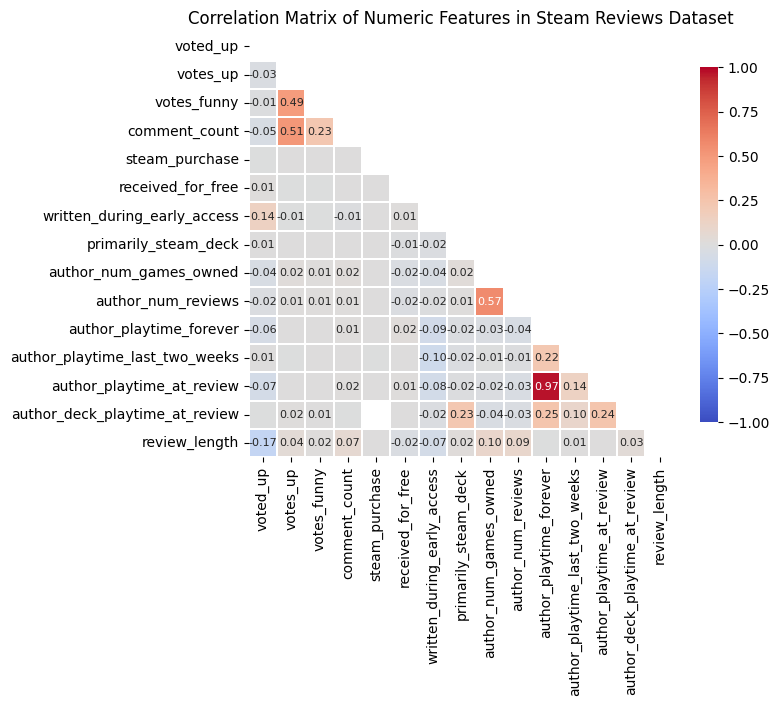

`author_playtime_forever` is highly positively correlated with `author_playtime_at_review` (0.97).


In [12]:
# Create correlation matrix for numeric columns only
corr_matrix = df.select_dtypes(include=[np.number, bool]).corr()

# Plot the correlation matrix
plt.figure(figsize=(8,8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 
cols = corr_matrix.columns
ax = sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    center=0,
    square=True,
    annot=True, 
    fmt='.2f',
    linewidths=0.1,
    cbar_kws={'shrink': 0.6},
    annot_kws={'size': 8},
    # Create custom annotations that hide zeros
)

# Manually update annotations to hide zeros
for text in ax.texts:
    if text.get_text() in ['0.00', '-0.00']:
        text.set_text('')
ax.set_xticks(np.arange(len(cols)) + 0.5) # Ensure every tick/label is shown 
ax.set_yticks(np.arange(len(cols)) + 0.5)
ax.set_xticklabels(cols, rotation=90)
ax.set_yticklabels(cols, rotation=0)
plt.tight_layout()
plt.title('Correlation Matrix of Numeric Features in Steam Reviews Dataset')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Get the absolute correlation matrix and set diagonal to 0 to ignore self-correlation
high_corr = corr_matrix.unstack().to_frame('correlation') # Unstack the correlation matrix
high_corr['sign'] = np.where(high_corr['correlation'] >= 0, 'positive', 'negative') # Add a new column indicating if the correlation is positive or negative
high_corr['correlation'] = high_corr['correlation'].abs().drop_duplicates()
high_corr = high_corr[high_corr['correlation'] < 1]
high_corr = high_corr.sort_values(by='correlation', ascending=False)
for (var1, var2), row in high_corr.head(1).iterrows():
    print(f"`{var1}` is highly {row['sign']}ly correlated with `{var2}` ({row['correlation']:.2f}).")

`author_playtime_forever` is highly positively correlated with `author_playtime_at_review` (0.97). This is expected, as the total playtime should be at least as much as the playtime at the time of review.

Here is a summary of the correlations between numeric features and the target variable `voted_up`:

1. Strong Positive Predictors ($r \ge 0.49$)
    - `comment_count` ($r = 0.51$): Strongest predictor; highly correlated with community discussion.

    - `votes_funny` ($r = 0.49$): Excellent proxy for overall positive engagement.

2. Moderate Positive Predictor ($r = 0.27$)

    - `weighted_vote_score` ($r = 0.27$): Moderately correlated with the raw number of upvotes.

3. Weak or Negligible Predictors ($r \le 0.04$)

    - `review_length` ($r = 0.04$): Length of the text is not a significant factor.

    - `author_num_games_owned` ($r = 0.02$): Author's library size is negligible.

    - `author_playtime_at_review` ($r = 0.00$): Zero linear correlation with upvotes received.

    - `author_playtime_forever` ($r = 0.00$): Total lifetime playtime is unrelated to upvotes.

We also verify that there are no duplicate rows in the dataset.

In [13]:
# Check duplicate rows
df_duplicates = df[df.duplicated()]
print(f"There are {df_duplicates.shape[0]:,} duplicate rows.")

There are 0 duplicate rows.




We also visualize the distribution of reviews over time.


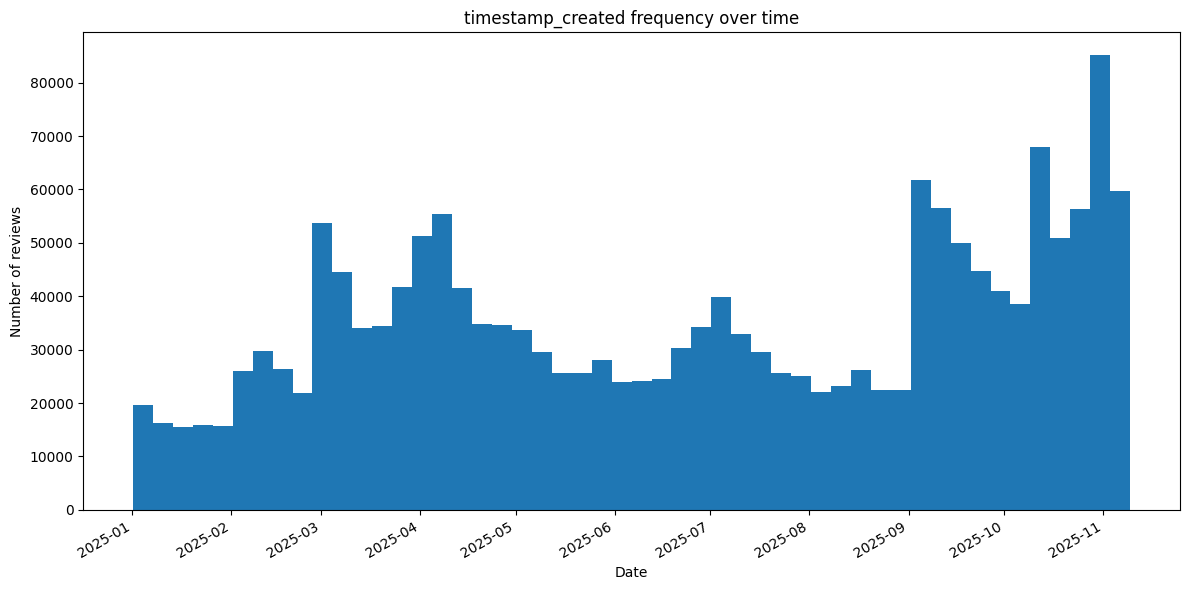

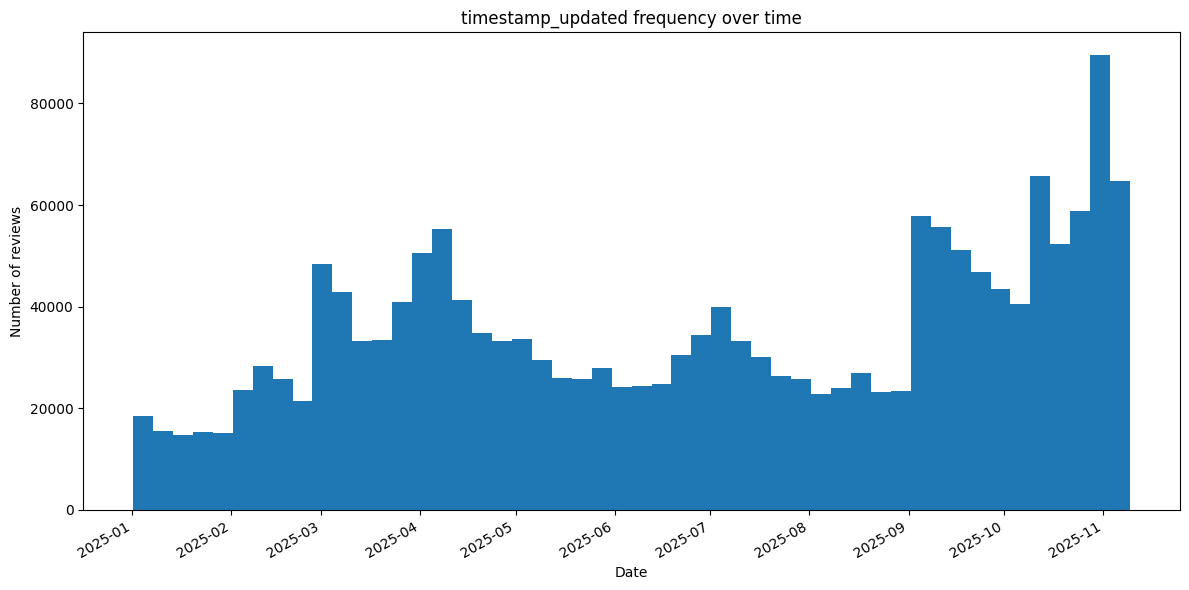

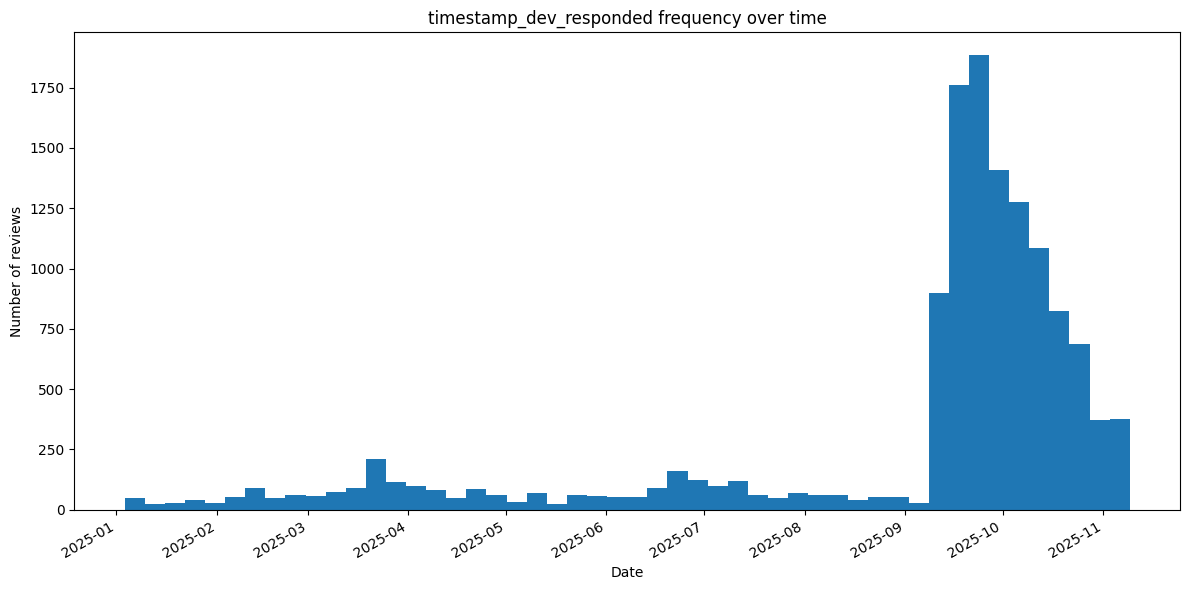

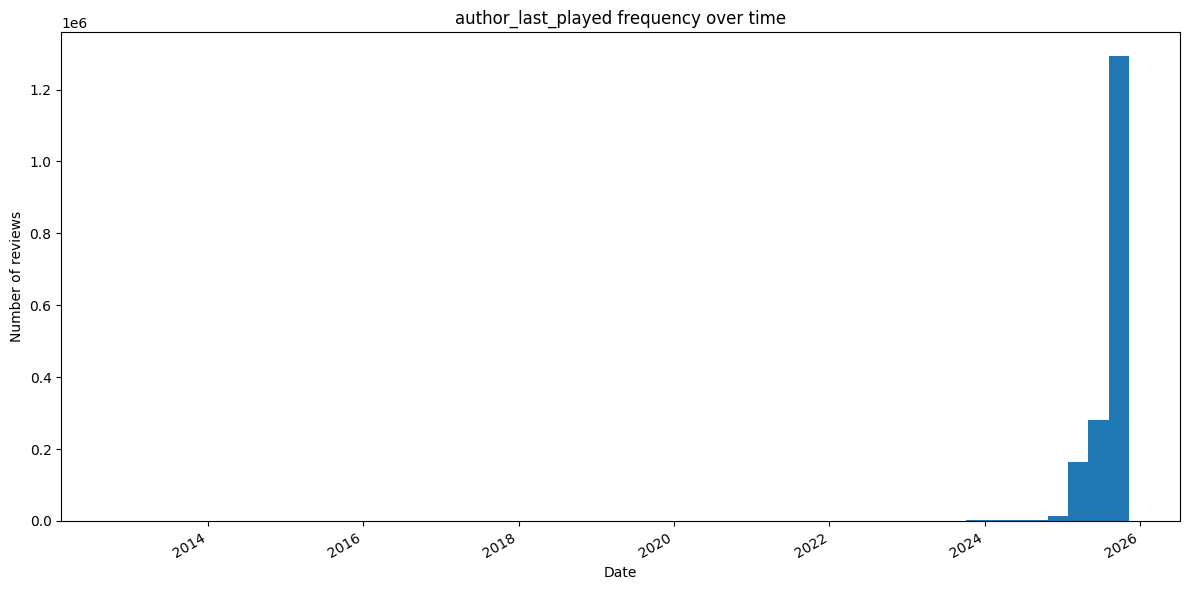

In [14]:
# Get datetime columns
timestamp_columns = ['timestamp_created', 'timestamp_updated', 'timestamp_dev_responded', 'author_last_played']
for col in timestamp_columns:
    # Histogram of review timestamps
    ts = df[col].dropna()
    plt.figure(figsize=(12,6))
    plt.hist(ts, bins=50)
    plt.xlabel('Date')
    plt.ylabel('Number of reviews')
    plt.title(f'{col} frequency over time')
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()





The number of upvotes, funny votes, and comments on reviews, as well as the playtime metrics, are all right-skewed, with most reviews having low values and a few reviews having very high values.


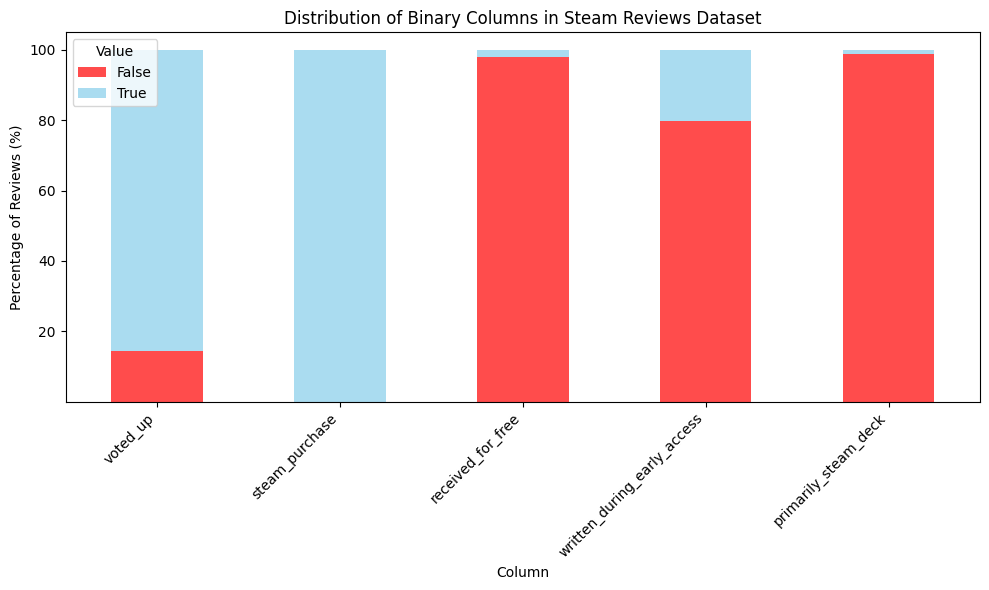

In [15]:
# Stacked bar chart for all binary columns
binary_columns = [col for col in df.columns if df[col].dropna().nunique() == 2]

# Compute percentages (of non-null values) for False/True for each binary column
false_counts = []
true_counts = []
for col in binary_columns:
    total = df[col].notnull().sum()
    if total == 0:
        false_counts.append(0.0)
        true_counts.append(0.0)
        continue
    false_counts.append(df[col].eq(False).sum() / total * 100)
    true_counts.append(df[col].eq(True).sum() / total * 100)

# Create DataFrame (remove unsupported kwargs from constructor)
counts_df = pd.DataFrame({'False': false_counts, 'True': true_counts}, index=binary_columns)

# Pass plotting color/alpha to the plot method instead
ax = counts_df.plot(kind='bar', stacked=True, figsize=(10,6), color=['red', 'skyblue'], alpha=0.7)
ax.set_xlabel('Column')
ax.set_ylabel('Percentage of Reviews (%)')
ax.set_title('Distribution of Binary Columns in Steam Reviews Dataset')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Value')
plt.tight_layout()
plt.show()

In [16]:
# See the numeric distribution of voted_up
df['voted_up'].value_counts()/df.shape[0]

voted_up
True     0.856659
False    0.143341
Name: count, dtype: float64

Many reviews had upvotes, almost all were purchased on Steam, most reviewers did not receive the game for free, about a fifth were written during early access of a game, and most reviewers did not play on a Steam Deck.

Importantly, we can see that `voted_up` is True in about 85% of all reviews. This means that our dependent is imbalanced which will need to be addressed when we build our model. We may need to focus on precision or recall in order to build a better model. 

### Target Variable: `voted_up`

In order to validate our results, we will look at a model that attempts to predict `voted_up` based on the other features of a review. This will help us understand if our results are justified.

#### `voted_up` Relationship with Categorical Variables

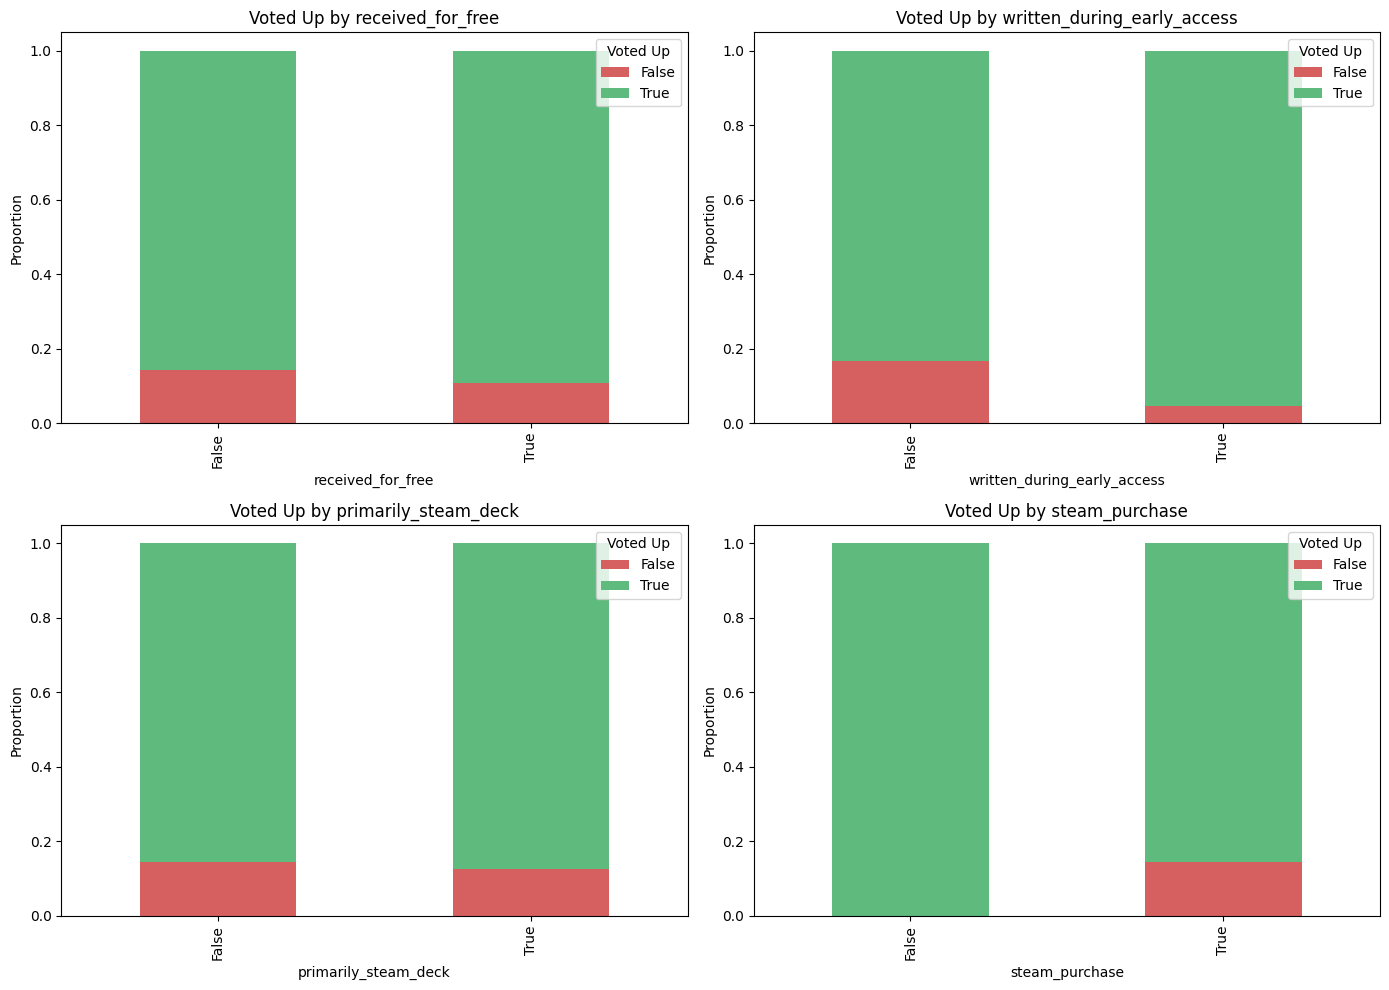

In [17]:
# Goal: See how boolean flags affect the vote ratio
bool_cols = ['received_for_free', 'written_during_early_access', 'primarily_steam_deck', 'steam_purchase']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(bool_cols):
    # Calculate percentages for normalized stacked bars
    ct = pd.crosstab(df[col], df['voted_up'], normalize='index')
    ct.plot(kind='bar', stacked=True, ax=axes[i], color=['#d65f5f', '#5fba7d'])
    axes[i].set_title(f'Voted Up by {col}')
    axes[i].set_ylabel('Proportion')
    axes[i].legend(title='Voted Up', loc='upper right')

plt.tight_layout()
plt.show()

In [18]:
for column in bool_cols:
    print(df[column].value_counts())

received_for_free
False    1739293
True       35669
Name: count, dtype: int64
written_during_early_access
False    1415108
True      359854
Name: count, dtype: int64
primarily_steam_deck
False    1756479
True       18483
Name: count, dtype: int64
steam_purchase
True     1774961
False          1
Name: count, dtype: int64


These graphs are a bit telling. We can see that:
1. Those who received the game for free were more likely to vote the game up. This group makes up a very small portion of the reviews, with only 35,669 reviews (approximately 2.0% of the total) coming from users who received the game for free.

2. Those who reviewed the game during early access were more likely to vote the game up. Reviews written during early access are a sizable minority, totaling 359,854 reviews (approximately 20.3% of the total).

3. Those who primarily use the steam deck are more likely to vote the game up. This is a small group, with only 18,483 reviews (approximately 1.0% of the total) coming from primary Steam Deck users.

4. Those who did not purchase the game on Steam seem to exclusively vote the game up. This observation is based on an extremely small sample size of only 1 review that was not purchased on Steam, compared to 1,774,961 reviews that were. The conclusion about this group is therefore statistically unreliable due to the count of one.

#### `voted_up` Relationship with Numeric Variables

/var/folders/dc/lsr79y5d6g75qdx4_s0tt9nh0000gn/T/ipykernel_53072/3050487850.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='voted_up', y='author_playtime_at_review', data=df, palette='Set2')


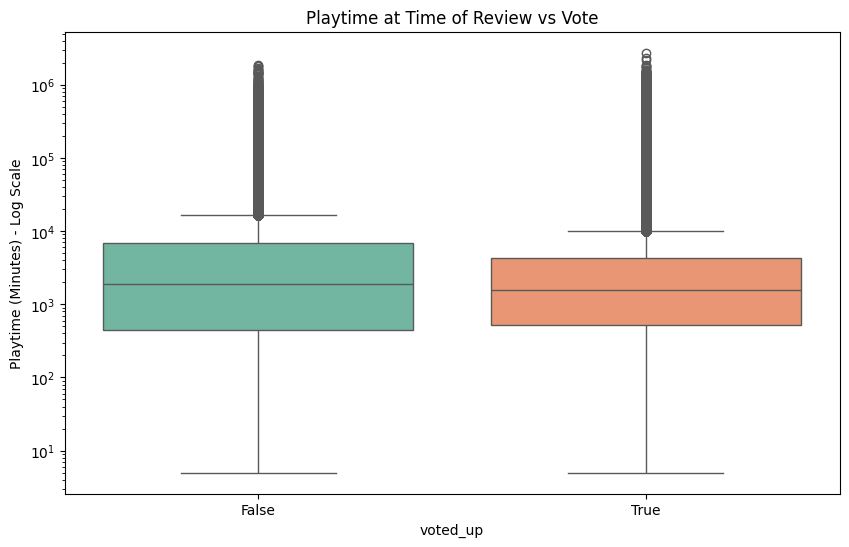

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='voted_up', y='author_playtime_at_review', data=df, palette='Set2')
plt.title('Playtime at Time of Review vs Vote')
plt.yscale('log') # Log scale handles the massive outliers typical in steam data
plt.ylabel('Playtime (Minutes) - Log Scale')
plt.show()

The median playtime is slightly higher for negative reviews, suggesting some users played the game extensively before deciding to vote it down, the overall distributions (especially the IQR) are very similar. This indicates that playtime alone is not a strong single predictor of a user's vote. The majority of positive and negative reviews come from users with comparable amounts of time played.

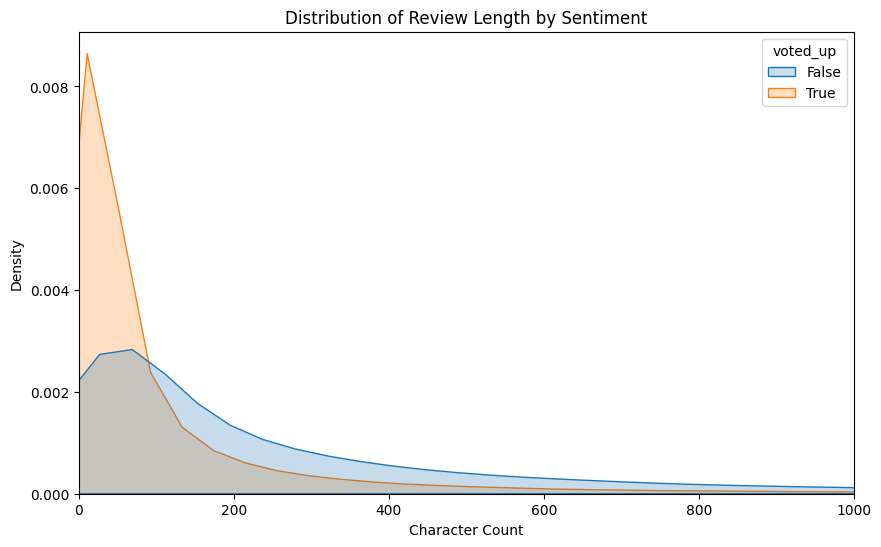

In [20]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='review_length', hue='voted_up', fill=True, common_norm=False)
plt.title('Distribution of Review Length by Sentiment')
plt.xlabel('Character Count')
plt.xlim(0, 1000) # Limiting x-axis to focus on the bulk of reviews
plt.show()

From this distribution of review length we can see that positive reviews are short, while negative reviews are generally more verbose. This confirms that the most common behavior for a happy user is a quick endorsement, whereas a critical user is more motivated to provide a detailed explanation. This difference in motivation leads to a sharp spike in density for positive reviews near zero length, while negative reviews have a flatter, longer distribution.

## Additional Data Preprocessing for Modeling

### Handle Categorical Variables

Instead of inlcuding a string `review` variable, we generate a sentiment score based on the review text using NLTK's VADER sentiment analysis tool. This score will help quantify the emotional tone of each review, providing an additional feature that may correlate with whether a review is positive or negative.

In [21]:
# Create sentiment score based on review text
sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['review'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

Then, we filter out any other categorical variables that are not useful for modeling--namely, ID variables and review text fields. 

In [22]:
columns_to_drop = ['recommendationid', 'author_steamid', 'game_appid', 'review']
df_dropped = df.copy()
df_dropped.drop(columns=columns_to_drop, inplace=True)

We also convert the categorical variable `language` into several dummy variables using one-hot encoding to make it suitable for modeling.

In [23]:
# One-hot encode language variable
df_dummies = df_dropped.copy()
df_dummies = pd.get_dummies(df_dummies, columns=['language'], drop_first=True)
df_dummies.head()

,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,...,review_length,sentiment_score,language_german,language_koreana,language_latam,language_norwegian,language_russian,language_tchinese,language_turkish,language_ukrainian
0,2025-11-04 14:30:07,2025-11-04 14:30:07,True,0,0,0.5,0,True,False,False,...,97,0.4404,False,False,False,False,False,False,False,False
1,2025-11-04 13:58:53,2025-11-04 13:58:53,True,0,0,0.5,0,True,False,False,...,189,0.6696,False,False,False,False,False,False,False,False
2,2025-11-04 13:57:22,2025-11-04 13:57:22,True,0,0,0.5,0,True,False,False,...,213,0.8905,False,False,False,False,False,False,False,False
3,2025-11-04 13:53:08,2025-11-04 13:53:08,True,0,0,0.5,0,True,False,False,...,444,0.9862,False,False,False,False,False,False,False,False
4,2025-11-04 13:17:10,2025-11-04 13:17:10,True,0,0,0.5,0,True,False,False,...,106,0.4767,False,False,False,False,False,False,False,False


### Standardize Features

We standardize the features to have mean 0 and standard deviation 1. Although the tree-based models from the previous assignment do not require standardization, this is important for SVMs since they are sensitive to the scale of the input features. We are using `RobustScaler()` to reduce the influence of outliers.

In [24]:
# Identify numerical columns
num_cols = df_dummies.select_dtypes(include=[np.number]).columns
df_standardized = df_dummies.copy()
scaler = RobustScaler()

# Fit and transform the numerical columns
df_standardized[num_cols] = scaler.fit_transform(df_standardized[num_cols])

df_standardized.head()

,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,...,review_length,sentiment_score,language_german,language_koreana,language_latam,language_norwegian,language_russian,language_tchinese,language_turkish,language_ukrainian
0,2025-11-04 14:30:07,2025-11-04 14:30:07,True,0.0,0.0,0.5,0.0,True,False,False,...,0.451613,0.026635,False,False,False,False,False,False,False,False
1,2025-11-04 13:58:53,2025-11-04 13:58:53,True,0.0,0.0,0.5,0.0,True,False,False,...,1.193548,0.349634,False,False,False,False,False,False,False,False
2,2025-11-04 13:57:22,2025-11-04 13:57:22,True,0.0,0.0,0.5,0.0,True,False,False,...,1.387097,0.660936,False,False,False,False,False,False,False,False
3,2025-11-04 13:53:08,2025-11-04 13:53:08,True,0.0,0.0,0.5,0.0,True,False,False,...,3.250000,0.795800,False,False,False,False,False,False,False,False
4,2025-11-04 13:17:10,2025-11-04 13:17:10,True,0.0,0.0,0.5,0.0,True,False,False,...,0.524194,0.077790,False,False,False,False,False,False,False,False


### Split and balance data

Lastly, we split the data into training and test sets and balance the training data.

In [25]:
# Separate features and target
X = df_standardized.drop(columns=['voted_up'])
y = df_standardized['voted_up']

# Randomly split the X and y arrays into 30 percent test data and 70 percent training data.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

In [26]:
# Balance training data
print(f"Unbalanced training set size: {X_train.shape[0]:,}")
print(f"Unbalanced training set class distribution: {Counter(y_train)}")
undersampler = RandomUnderSampler(random_state=1)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
print(f"Resampled training set size: {X_train_resampled.shape[0]:,}")
print(f"Resampled training set class distribution: {Counter(y_train_resampled)}")

Unbalanced training set size: 1,242,473
Unbalanced training set class distribution: Counter({True: 1064376, False: 178097})
Resampled training set size: 356,194
Resampled training set class distribution: Counter({False: 178097, True: 178097})


Our data is ready for us train our models.

## Create Model 1 (from weeks 1-10)

Firstly, we anticipate the need to compare our models so we'll compile all of our models' results into one list.

In [ ]:
all_model_results = []

In this section, we train and validate the SVM model and tune hyper-parameters. For all models, we split the data into 70% for training and 30% for testing. We will start with a linear kernel and the regularization parameter C=1.0 (default).

In [ ]:
# Separate features and target
X = df_standardized.drop(columns=['y'])
y = df_standardized['y']

# Randomly split the X and y arrays into 30 percent test data and 70 percent training data.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

# Create and train the SVM model
svm_linear = SVC(kernel='linear', C=1.0, random_state=1)
svm_linear.fit(X_train, y_train)

# Display a detailed classification report
y_pred_svm = svm_linear.predict(X_test) # Predictions on test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_svm))

# Accuracy on balanced training set
y_train_pred = svm_linear.predict(X_train) # Predictions on training set
train_acc = accuracy_score(y_train, y_train_pred)
print('Training Accuracy: %.2f%%' % (train_acc * 100))

# Accuracy on test set
test_acc = accuracy_score(y_test, y_pred_svm)
print('Test Accuracy: %.2f%%' % (test_acc * 100))

# Recall on the test set
test_recall_svm = recall_score(y_test, y_pred_svm)
print('Final Model Recall on Test Set:  %.2f%%' % (test_recall_svm * 100))


Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.91      0.99      0.94     10197
        True       0.63      0.19      0.30      1277

    accuracy                           0.90     11474
   macro avg       0.77      0.59      0.62     11474
weighted avg       0.88      0.90      0.87     11474

Training Accuracy: 89.83%
Test Accuracy: 89.78%
Final Model Recall on Test Set:  19.26%


In [ ]:
report = classification_report(y_test, y_pred_svm, output_dict=True)

# Adding an entry to the model results list
all_model_results.append({
    'model': 'SVM (Linear)',
    'train_acc': accuracy_score(y_train, y_train_pred),
    'test_acc': report['accuracy'],
    'test_recall': recall_score(y_test, y_pred_svm),
    'precision_macro': report['macro avg']['precision'],
    'recall_macro': report['macro avg']['recall'],
    'f1_macro': report['macro avg']['f1-score'],
    'precision_weighted': report['weighted avg']['precision'],
    'recall_weighted': report['weighted avg']['recall'],
    'f1_weighted': report['weighted avg']['f1-score']
})

The SVM model predicts bank subscriptions with 89.78% accuracy on the test set. Training and test accuracies are similar and do not indicate overfitting. The F1 score for the positive class (subscribed) is 0.30.

We will also explore using the RBF kernel (default).

In [ ]:
# Create and train the SVM model
svm_rbf = SVC(kernel='rbf', C=1.0, random_state=1)
svm_rbf.fit(X_train, y_train)

# Display a more detailed classification report
y_train_pred = svm_rbf.predict(X_train) # Predictions on training set
y_pred_svm = svm_rbf.predict(X_test) # Predictions on test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_svm))

# Accuracy on training set
train_acc = accuracy_score(y_train, y_train_pred)
print('Training Accuracy: %.2f%%' % (train_acc * 100))

# Accuracy on test set
test_acc = accuracy_score(y_test, y_pred_svm)
print('Test Accuracy: %.2f%%' % (test_acc * 100))

# Calculate final recall on the test set
test_recall_svm = recall_score(y_test, y_pred_svm)
print('Final Model Recall on Test Set: %.2f%%' % (test_recall_svm * 100))


Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.91      0.98      0.94     10197
        True       0.63      0.21      0.32      1277

    accuracy                           0.90     11474
   macro avg       0.77      0.60      0.63     11474
weighted avg       0.88      0.90      0.88     11474

Training Accuracy: 90.51%
Test Accuracy: 89.82%
Final Model Recall on Test Set: 21.30%


In [ ]:
# Get the report as a dictionary (uses y_pred_svm from the rbf model)
report = classification_report(y_test, y_pred_svm, output_dict=True)

# Adding an entry to the model results list
all_model_results.append({
    'model': 'SVM (rbf)',
    'train_acc': accuracy_score(y_train, y_train_pred),
    'test_acc': report['accuracy'],
    'test_recall': recall_score(y_test, y_pred_svm),
    'precision_macro': report['macro avg']['precision'],
    'recall_macro': report['macro avg']['recall'],
    'f1_macro': report['macro avg']['f1-score'],
    'precision_weighted': report['weighted avg']['precision'],
    'recall_weighted': report['weighted avg']['recall'],
    'f1_weighted': report['weighted avg']['f1-score']
})

The test accuracy is slightly improved with the RBF kernel (from 89.78% to 89.82%) and the F1 score is also improved (from 0.30 to 0.32). 

Given these improved results, we will proceed with hyper-parameter tuning to see if we can improve performance further.

In [ ]:
# Tune hyper-parameters 
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01, 0.001],
}
grid_search_svm = GridSearchCV(
    estimator=svm_rbf,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

# Train the model
grid_search_svm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10],
                         'gamma': ['scale', 'auto', 0.01, 0.001]},
             scoring='recall')

In [ ]:
# Display best parameters
print("Best Hyper-parameters:", grid_search_svm.best_params_)

# Display a more detailed classification report
y_pred_svm = grid_search_svm.predict(X_test) # Predictions on test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_svm))

# Accuracy on training set
y_train_pred = grid_search_svm.predict(X_train) # Predictions on training set
train_acc = accuracy_score(y_train, y_train_pred)
print('Training Accuracy: %.2f%%' % (train_acc * 100))

# Accuracy on test set
test_acc = accuracy_score(y_test, y_pred_svm)
print('Test Accuracy: %.2f%%' % (test_acc * 100))

# Calculate final recall on the test set
test_recall_svm = recall_score(y_test, y_pred_svm)
print('Final Model Recall on Test Set:  %.2f%%' % (test_recall_svm * 100))
print('Best Cross-Validation Recall Score:  %.2f%%' % (grid_search_svm.best_score_ * 100))

Best Hyper-parameters: {'C': 10, 'gamma': 'scale'}

Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.91      0.98      0.94     10197
        True       0.60      0.24      0.34      1277

    accuracy                           0.90     11474
   macro avg       0.75      0.61      0.64     11474
weighted avg       0.88      0.90      0.88     11474

Training Accuracy: 91.76%
Test Accuracy: 89.73%
Final Model Recall on Test Set:  24.12%
Best Cross-Validation Recall Score:  24.52%


In [ ]:
# Get the report as a dictionary (uses y_pred_svm from grid search)
report = classification_report(y_test, y_pred_svm, output_dict=True)

# Adding an entry to the model results list
all_model_results.append({
    'model': 'SVM (GridSearch)',
    'train_acc': accuracy_score(y_train, y_train_pred),
    'test_acc': report['accuracy'],
    'test_recall': recall_score(y_test, y_pred_svm),
    'precision_macro': report['macro avg']['precision'],
    'recall_macro': report['macro avg']['recall'],
    'f1_macro': report['macro avg']['f1-score'],
    'precision_weighted': report['weighted avg']['precision'],
    'recall_weighted': report['weighted avg']['recall'],
    'f1_weighted': report['weighted avg']['f1-score'],
    'best_cv_score': grid_search_svm.best_score_,
    'best_params': grid_search_svm.best_params_
})

The hyper-parameter tuning yielded an accuracy of 89.73%, which is a slight decrease from the previous RBF model. However, since the grid search was optimized for recall, we see an improvement in recall from 21.3% to 24.12%, meaning the model can identify more of the positive class (subscribed) instances. The F1 score also improved slightly from 0.32 to 0.34.

Lastly, we try balancing the training data.

In [ ]:
# Balance training data
print(f"Unbalanced training set size: {X_train.shape[0]:,}")
print(f"Unbalanced training set class distribution: {Counter(y_train)}")
undersampler = RandomUnderSampler(random_state=1)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
print(f"Resampled training set size: {X_train_resampled.shape[0]:,}")
print(f"Resampled training set class distribution: {Counter(y_train_resampled)}")

# Train the optimized model on the balanced data
grid_search_svm.fit(X_train_resampled, y_train_resampled)

# Display a more detailed classification report
y_pred_svm = grid_search_svm.predict(X_test) # Predictions on test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_svm))

# Accuracy on training set
y_train_pred = grid_search_svm.predict(X_train_resampled) # Predictions on (balanced) training set
train_acc = accuracy_score(y_train_resampled, y_train_pred)
print('Training Accuracy: %.2f%%' % (train_acc * 100))
print('Best Cross-Validation Recall Score on Training Set: %.2f%%' % (grid_search_svm.best_score_ * 100))

# Accuracy on test set
test_acc = accuracy_score(y_test, y_pred_svm)
print('Test Accuracy: %.2f%%' % (test_acc * 100))

# Calculate final recall on the test set
test_recall_svm = recall_score(y_test, y_pred_svm)
print('Final Model Recall on Test Set:  %.2f%%' % (test_recall_svm * 100))

Unbalanced training set size: 26,771
Unbalanced training set class distribution: Counter({False: 23790, True: 2981})
Resampled training set size: 5,962
Resampled training set class distribution: Counter({False: 2981, True: 2981})

Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.95      0.72      0.82     10197
        True       0.24      0.70      0.36      1277

    accuracy                           0.72     11474
   macro avg       0.60      0.71      0.59     11474
weighted avg       0.87      0.72      0.77     11474

Training Accuracy: 71.15%
Best Cross-Validation Recall Score on Training Set: 70.41%
Test Accuracy: 72.01%
Final Model Recall on Test Set:  70.48%


In [ ]:
# Get the report as a dictionary
report = classification_report(y_test, y_pred_svm, output_dict=True)

# Adding an entry to the model results list
all_model_results.append({
    'model': 'SVM (GridSearch, Undersampled)',
    'train_acc': accuracy_score(y_train_resampled, y_train_pred),
    'test_acc': report['accuracy'],
    'test_recall': recall_score(y_test, y_pred_svm),
    'precision_macro': report['macro avg']['precision'],
    'recall_macro': report['macro avg']['recall'],
    'f1_macro': report['macro avg']['f1-score'],
    'precision_weighted': report['weighted avg']['precision'],
    'recall_weighted': report['weighted avg']['recall'],
    'f1_weighted': report['weighted avg']['f1-score'],
    'best_cv_score': grid_search_svm.best_score_,
    'best_params': grid_search_svm.best_params_
})

Balancing the data made the accuracy drop significantly (nearly 20 percentage points), but we do see a substantial improvement in recall (from 24.12% to 70.48%). This means the model is able to identify a much larger proportion of the positive class (subscribed) instances, but at the cost of many more false positives. I.e., many more clients are incorrectly predicted to subscribe when they do not, but we are able to identify many more clients who do subscribe. If the bank has the resources to cast a wider net with more potential clients, this trade-off may be acceptable.

## Create Model 2 (from weeks 11-15)

We compare the results of the SVM model above with the decision tree, random forest, and AdaBoost models from the previous homework. We detail the model parameters and results of evaluation metrics for each experiment below and compare them with the SVM result.

#### Decision Tree 1

Decision tree with max depth of 4.

In [ ]:
# Create and fit decision tree 1
tree_model_1 = DecisionTreeClassifier(criterion='gini',
                                     max_depth=4,
                                     random_state=1)
tree_model_1.fit(X_train, y_train)

# Display a detailed classification report
y_pred_tree1 = tree_model_1.predict(X_test) # Predictions on test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_tree1))

# Accuracy on training set
y_train_pred_tree1 = tree_model_1.predict(X_train) # Predictions on training set
train_acc = accuracy_score(y_train, y_train_pred_tree1)
print('Training Accuracy: %.2f%%' % (train_acc * 100))

# Accuracy on test set
test_acc_tree1 = accuracy_score(y_test, y_pred_tree1)
print('Test Accuracy: %.2f%%' % (test_acc_tree1 * 100))

# Recall on the test set
test_recall_tree1 = recall_score(y_test, y_pred_tree1)
print('Recall on Test Set: %.2f%%' % (test_recall_tree1 * 100))


Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.91      0.99      0.95     10197
        True       0.69      0.18      0.28      1277

    accuracy                           0.90     11474
   macro avg       0.80      0.58      0.61     11474
weighted avg       0.88      0.90      0.87     11474

Training Accuracy: 90.06%
Test Accuracy: 89.95%
Recall on Test Set: 17.70%


In [ ]:
# Get the report as a dictionary
report = classification_report(y_test, y_pred_tree1, output_dict=True)

# Adding an entry to the model results list
all_model_results.append({
    'model': 'Decision Tree (Depth 4)',
    'train_acc': accuracy_score(y_train, y_train_pred_tree1),
    'test_acc': report['accuracy'],
    'test_recall': recall_score(y_test, y_pred_tree1),
    'precision_macro': report['macro avg']['precision'],
    'recall_macro': report['macro avg']['recall'],
    'f1_macro': report['macro avg']['f1-score'],
    'precision_weighted': report['weighted avg']['precision'],
    'recall_weighted': report['weighted avg']['recall'],
    'f1_weighted': report['weighted avg']['f1-score']
})

The decision tree model with a max depth of 4 was 89.95% accurate on the test data, much better than the final SVM model (72.01%), but had lower recall (17.70% vs. 70.48%) and F1 score (0.28 vs. 0.36) for the positive class (subscribed).

#### Decision Tree 2

Decision tree pruned to have a max depth of 2.

In [ ]:
# Create and fit a decision tree model
tree_model_2 = DecisionTreeClassifier(criterion='gini',
                                     max_depth=2, # Decrease max depth to 2
                                     random_state=1)
tree_model_2.fit(X_train, y_train)

# Display a detailed classification report
y_pred_tree2 = tree_model_2.predict(X_test) # Predictions on test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_tree2))

# Accuracy on training set
y_train_pred_tree2 = tree_model_2.predict(X_train) # Predictions on training set
train_acc = accuracy_score(y_train, y_train_pred_tree2)
print('Training Accuracy: %.2f%%' % (train_acc * 100))

# Accuracy on test set
test_acc_tree2 = accuracy_score(y_test, y_pred_tree2)
print('Test Accuracy: %.2f%%' % (test_acc_tree2 * 100))

# Recall on the test set
test_recall_tree2 = recall_score(y_test, y_pred_tree2)
print('Recall on Test Set: %.2f%%' % (test_recall_tree2 * 100))



Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.91      0.99      0.95     10197
        True       0.70      0.17      0.28      1277

    accuracy                           0.90     11474
   macro avg       0.80      0.58      0.61     11474
weighted avg       0.88      0.90      0.87     11474

Training Accuracy: 90.02%
Test Accuracy: 89.96%
Recall on Test Set: 17.31%


In [ ]:
# Get the report as a dictionary
report = classification_report(y_test, y_pred_tree2, output_dict=True)

# Adding an entry to the model results list
all_model_results.append({
    'model': 'Decision Tree (Depth 2)',
    'train_acc': accuracy_score(y_train, y_train_pred_tree2),
    'test_acc': report['accuracy'],
    'test_recall': recall_score(y_test, y_pred_tree2),
    'precision_macro': report['macro avg']['precision'],
    'recall_macro': report['macro avg']['recall'],
    'f1_macro': report['macro avg']['f1-score'],
    'precision_weighted': report['weighted avg']['precision'],
    'recall_weighted': report['weighted avg']['recall'],
    'f1_weighted': report['weighted avg']['f1-score']
})

The decision tree model with a max depth of 2 was 89.96% accurate, which is still better than the final SVM model (72.01%). However, it had even lower recall than the previous decision tree (17.31%), making the SVM model preferable.

#### Random Forest 1

Random forest with 25 trees.

In [ ]:
# Generate RF model
forest_1 = RandomForestClassifier(n_estimators=25,
                                random_state=1,
                                n_jobs=2)
forest_1.fit(X_train, y_train)

# Display a detailed classification report
y_pred_forest1 = forest_1.predict(X_test) # Predictions on test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_forest1))

# Accuracy on training set
y_train_pred_forest1 = forest_1.predict(X_train) # Predictions on training set
train_acc = accuracy_score(y_train, y_train_pred_forest1)
print('Training Accuracy: %.2f%%' % (train_acc * 100))

# Accuracy on test set
test_acc_forest1 = accuracy_score(y_test, y_pred_forest1)
print('Test Accuracy: %.2f%%' % (test_acc_forest1 * 100))

# Recall on the test set
test_recall_forest1 = recall_score(y_test, y_pred_forest1)
print('Recall on Test Set:  %.2f%%' % (test_recall_forest1 * 100))


Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.92      0.97      0.94     10197
        True       0.54      0.30      0.38      1277

    accuracy                           0.89     11474
   macro avg       0.73      0.63      0.66     11474
weighted avg       0.87      0.89      0.88     11474

Training Accuracy: 99.15%
Test Accuracy: 89.32%
Recall on Test Set:  29.68%


In [ ]:
# Get the report as a dictionary
report = classification_report(y_test, y_pred_forest1, output_dict=True)

# Adding an entry to the model results list
all_model_results.append({
    'model': 'Random Forest (n=25)',
    'train_acc': accuracy_score(y_train, y_train_pred_forest1),
    'test_acc': report['accuracy'],
    'test_recall': recall_score(y_test, y_pred_forest1),
    'precision_macro': report['macro avg']['precision'],
    'recall_macro': report['macro avg']['recall'],
    'f1_macro': report['macro avg']['f1-score'],
    'precision_weighted': report['weighted avg']['precision'],
    'recall_weighted': report['weighted avg']['recall'],
    'f1_weighted': report['weighted avg']['f1-score']
})

This random forest model is less accurate than the previous decision tree models at 89.36% accuracy in correctly predicting a subscriber, but it is still more accurate than the SVM model. However, since the training accuracy is very high at 99.15% (nearly a perfect fit to the training data!), this may indicate overfitting. The recall of the model is very poor. It is only correctly identifying 29.68% of true positives (subscribers) compared to 70.48% for the SVM model.

#### Random Forest 2

Random forest with grid search over number of trees (10-50, in increments of 5) and max depth (2-6 and None, in increments of 1) using 5 fold cross validation.

In [ ]:
# Set up our parameters for grid search
param_grid = {
    'n_estimators': [10, 15, 20, 25, 30, 35, 40, 45, 50],
    'max_depth': [2, 3, 4, 5, 6, None]
}

# Initialize our random forest classifier
forest_2 = RandomForestClassifier(random_state=1)

# Set up the grid search with recall as the scoring metric
grid_search = GridSearchCV(
    estimator=forest_2,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1 # This allows us to use all available cores to speed up the training
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Get the best model from the grid search
best_forest = grid_search.best_estimator_

Best Hyperparameters: {'max_depth': None, 'n_estimators': 25}


In [ ]:
# Display a more detailed classification report
y_pred_best_forest = best_forest.predict(X_test)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_best_forest))

# Accuracy on training set
y_train_pred = best_forest.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print('Training Accuracy: %.2f%%' % (train_acc * 100))

# Accuracy on test set
test_acc = accuracy_score(y_test, y_pred_best_forest)
print('Test Accuracy: %.2f%%' % (test_acc * 100))

# Calculate final recall on the test set
test_recall_rf2 = recall_score(y_test, y_pred_best_forest)
print('Final Model Recall on Test Set:  %.2f%%' % (test_recall_rf2 * 100))
print('Best Cross-Validation Recall Score:  %.2f%%' % (grid_search.best_score_ * 100))


Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.92      0.97      0.94     10197
        True       0.54      0.30      0.38      1277

    accuracy                           0.89     11474
   macro avg       0.73      0.63      0.66     11474
weighted avg       0.87      0.89      0.88     11474

Training Accuracy: 99.15%
Test Accuracy: 89.32%
Final Model Recall on Test Set:  29.68%
Best Cross-Validation Recall Score:  28.14%


In [ ]:
# Get the report as a dictionary
report = classification_report(y_test, y_pred_best_forest, output_dict=True)

# Adding an entry to the model results list
all_model_results.append({
    'model': 'Random Forest (GridSearch)',
    'train_acc': accuracy_score(y_train, y_train_pred),
    'test_acc': report['accuracy'],
    'test_recall': recall_score(y_test, y_pred_best_forest),
    'precision_macro': report['macro avg']['precision'],
    'recall_macro': report['macro avg']['recall'],
    'f1_macro': report['macro avg']['f1-score'],
    'precision_weighted': report['weighted avg']['precision'],
    'recall_weighted': report['weighted avg']['recall'],
    'f1_weighted': report['weighted avg']['f1-score'],
    'best_cv_score': grid_search.best_score_,
    'best_params': grid_search.best_params_
})

This random forest model is even less accurate than the prior random forest, at 89.32% accuracy in correctly predicting subscribers in the test data, but this still performs better than the SVM (70.48%). Unfortunately, since the training accuracy is very high at 98.79% (nearly a perfect fit to the training data!), this one also shows signs of overfitting. Additionally, the recall of the model (29.68%) is very poor compared to the SVM (70.48%).

#### AdaBoost 1

Adaboost with 50 estimators and learning rate of 1.

In [ ]:
# train the adaboost algorithm
adaboost_1 = AdaBoostClassifier(
    n_estimators=50,
    learning_rate=1,
    random_state=1
)

# Train our model
adaboost_1.fit(X_train, y_train)

# Display a more detailed classification report
y_pred_ada_1 = adaboost_1.predict(X_test)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_ada_1))

# Accuracy on training set
y_train_pred = adaboost_1.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print('Training Accuracy: %.2f%%' % (train_acc * 100))

# Accuracy on test set
test_acc = accuracy_score(y_test, y_pred_ada_1)
print('Test Accuracy: %.2f%%' % (test_acc * 100))

# Calculate final recall on the test set
test_recall_ada_1 = recall_score(y_test, y_pred_ada_1)
print('Final Model Recall on Test Set:  %.2f%%' % (test_recall_ada_1 * 100))


Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.91      0.99      0.95     10197
        True       0.70      0.17      0.28      1277

    accuracy                           0.90     11474
   macro avg       0.80      0.58      0.61     11474
weighted avg       0.88      0.90      0.87     11474

Training Accuracy: 90.03%
Test Accuracy: 89.97%
Final Model Recall on Test Set:  17.38%


In [ ]:
# Get the report as a dictionary
report = classification_report(y_test, y_pred_ada_1, output_dict=True)

# Adding an entry to the model results list
all_model_results.append({
    'model': 'AdaBoost (n=50, lr=1)',
    'train_acc': accuracy_score(y_train, y_train_pred),
    'test_acc': report['accuracy'],
    'test_recall': recall_score(y_test, y_pred_ada_1),
    'precision_macro': report['macro avg']['precision'],
    'recall_macro': report['macro avg']['recall'],
    'f1_macro': report['macro avg']['f1-score'],
    'precision_weighted': report['weighted avg']['precision'],
    'recall_weighted': report['weighted avg']['recall'],
    'f1_weighted': report['weighted avg']['f1-score']
})

The AdaBoost model, configured with 50 estimators and a learning rate of 1, achieved a final recall of 17.38% on the test set. This really low score means that the model is failing to identify about 83% of actual customers with subscriptions--much lower than the final SVM model (70.48%). Despite this, the model showed high precision (70%) meaning that there's a strong chance that any customer predicted to subscribe actually does so. The high accuracy of 90% is misleading due to the imbalanced dataset, even though it is better than the SVM model (72.01%).

#### AdaBoost 2

A resampled dataset to balance the dataset and an optimized Adaboost model using a range of estimators (20-300 in increments of 25) and learning rates (0-1 in increments of 0.05) using 5-fold cross validation.

In [ ]:
# Firstly, we will balance the dataset by undersampling the majority class
undersampler = RandomUnderSampler(random_state=1)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

print(f"Resample training set size: {X_train_resampled.shape[0]:,}")

Resample training set size: 5,962


In [ ]:
# Now we'll set up our grid search
param_grid = {
    'n_estimators': list(range(20, 301, 25)),
    'learning_rate': [round(x, 2) for x in np.arange(0.1, 1.01, 0.05)],
}

# Creating our AdaBoost classifier
ada_boost_2 = AdaBoostClassifier(random_state=1)

grid_search_ada = GridSearchCV(
    estimator=ada_boost_2,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1 # With our wide range of hyperparameters, we're going to need to use all available cores to speed up the training
)

# Run the grid search on the resampled training data
grid_search_ada.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=1), n_jobs=-1,
             param_grid={'learning_rate': [np.float64(0.1), np.float64(0.15),
                                           np.float64(0.2), np.float64(0.25),
                                           np.float64(0.3), np.float64(0.35),
                                           np.float64(0.4), np.float64(0.45),
                                           np.float64(0.5), np.float64(0.55),
                                           np.float64(0.6), np.float64(0.65),
                                           np.float64(0.7), np.float64(0.75),
                                           np.float64(0.8), np.float64(0.85),
                                           np.float64(0.9), np.float64(0.95),
                                           np.float64(1.0)],
                         'n_estimators': [20, 45, 70, 95, 120, 145, 170, 195,
                                          220, 245, 270, 295]},
             scoring='recall')

In [ ]:
print(f"Best Hyperparameters Found: {grid_search_ada.best_params_}")
best_ada = grid_search_ada.best_estimator_

# Display a more detailed classification report
y_pred_ada2 = best_ada.predict(X_test)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_ada2))

# Accuracy on (balanced) training set
y_train_pred = best_ada.predict(X_train_resampled)
train_acc = accuracy_score(y_train_resampled, y_train_pred)
print('Training Accuracy: %.2f%%' % (train_acc * 100))
print('Best Cross-Validation Recall Score on Training Set:  %.2f%%' % (grid_search_ada.best_score_ * 100))

# Accuracy on test set
test_acc = accuracy_score(y_test, y_pred_ada2)
print('Test Accuracy: %.2f%%' % (test_acc * 100))

# Calculate final recall on the test set
test_recall_ada2 = recall_score(y_test, y_pred_ada2)
print('Final Model Recall on Test Set:  %.2f%%' % (test_recall_ada2 * 100))

Best Hyperparameters Found: {'learning_rate': np.float64(0.85), 'n_estimators': 20}

Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.95      0.74      0.83     10197
        True       0.25      0.70      0.37      1277

    accuracy                           0.73     11474
   macro avg       0.60      0.72      0.60     11474
weighted avg       0.87      0.73      0.78     11474

Training Accuracy: 71.50%
Best Cross-Validation Recall Score on Training Set:  70.24%
Test Accuracy: 73.26%
Final Model Recall on Test Set:  69.77%


In [ ]:
# Get the report as a dictionary
report = classification_report(y_test, y_pred_ada2, output_dict=True)

# Adding an entry to the model results list
all_model_results.append({
    'model': 'AdaBoost (GridSearch, Undersampled)',
    'train_acc': accuracy_score(y_train_resampled, y_train_pred),
    'test_acc': report['accuracy'],
    'test_recall': recall_score(y_test, y_pred_ada2),
    'precision_macro': report['macro avg']['precision'],
    'recall_macro': report['macro avg']['recall'],
    'f1_macro': report['macro avg']['f1-score'],
    'precision_weighted': report['weighted avg']['precision'],
    'recall_weighted': report['weighted avg']['recall'],
    'f1_weighted': report['weighted avg']['f1-score'],
    'best_cv_score': grid_search_ada.best_score_,
    'best_params': grid_search_ada.best_params_
})

From our grid search, our optimal AdaBoost model has a learning rate of 0.85 and 20 estimators. This method seems to be highly effective as we have a high recall indicating that we are able to correctly identify 69.77% of actual subscribers in the test set, only slightly worse than the final SVM at 70.48%. However, the precision is quite low at 25% meaning that many of our predictions are false positives--slightly more false positives than the 24% in the SVM. Despite this, the AdaBoost model still have a fairly good accuracy of 73.26%, which is 1% better than the SVM model at 72.01%.

### Summary Figure

Now that we've completed our last model, we'll display all of our results here in a figure for easy comparison:

In [ ]:
results_df = pd.DataFrame(all_model_results)
results_df.set_index('model', inplace=True)
sorted_results_df = results_df.sort_values(by='recall_macro', ascending=False)

pct_cols = ['train_acc','test_acc','test_recall',
            'precision_macro','recall_macro','f1_macro',
            'precision_weighted','recall_weighted','f1_weighted',
            'best_cv_score']

fmt = results_df.copy()
for c in pct_cols:
    if c in fmt.columns:
        fmt[c] = (fmt[c]).round(4)

# sort by recall_macro as before and display
fmt = fmt.sort_values(by='recall_macro', ascending=False)
print("--- Model Comparison Table (Sorted by Macro Recall) ---")
fmt

--- Model Comparison Table (Sorted by Macro Recall) ---


,train_acc,test_acc,test_recall,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,best_cv_score,best_params
model,,,,,,,,,,,
"AdaBoost (GridSearch, Undersampled)",0.7150,0.7326,0.6977,0.6003,0.7174,0.5990,0.8730,0.7326,0.7789,0.7024,"{'learning_rate': 0.85, 'n_estimators': 20}"
"SVM (GridSearch, Undersampled)",0.7115,0.7201,0.7048,0.5961,0.7134,0.5900,0.8722,0.7201,0.7695,0.7041,"{'C': 1, 'gamma': 0.001}"
Random Forest (n=25),0.9915,0.8932,0.2968,0.7267,0.6324,0.6619,0.8743,0.8932,0.8793,NaN,NaN
Random Forest (GridSearch),0.9915,0.8932,0.2968,0.7267,0.6324,0.6619,0.8743,0.8932,0.8793,0.2814,"{'max_depth': None, 'n_estimators': 25}"
SVM (GridSearch),0.9176,0.8973,0.2412,0.7537,0.6103,0.6438,0.8764,0.8973,0.8774,0.2452,"{'C': 10, 'gamma': 'scale'}"
SVM (rbf),0.9051,0.8982,0.2130,0.7671,0.5985,0.6314,0.8774,0.8982,0.8752,NaN,NaN
SVM (Linear),0.8983,0.8978,0.1926,0.7705,0.5894,0.6202,0.8766,0.8978,0.8726,NaN,NaN
Decision Tree (Depth 4),0.9006,0.8995,0.1770,0.7974,0.5835,0.6138,0.8816,0.8995,0.8720,NaN,NaN
"AdaBoost (n=50, lr=1)",0.9003,0.8997,0.1738,0.8018,0.5822,0.6122,0.8824,0.8997,0.8718,NaN,NaN


## Conclusion

> Make your conclusions from your analysis. Please be sure to address the business impact (it could be of any domain) of your solution.